
# Softmax Implementation for Linear Classifier


This project will teach you how to implement softmax activation and use PyTorch's automatic differentiation for training a linear classifier. You will:

1. **Implement softmax activation function** for multi-class classification with numerical stability
2. **Use PyTorch's automatic differentiation** instead of manual gradient computation
3. **Train a linear classifier** using default hyperparameters (lr=0.001, batch_size=32)
4. **Test the trained classifier on MNIST dataset** and achieve >90% accuracy
5. **Load pre-saved weights** and compare with the original linear classifier from 01_linear_feature.ipynb

**Important**: This notebook focuses on understanding softmax implementation and PyTorch's automatic differentiation. We will use PyTorch's cross-entropy loss function and optimizer for training.

***NOTE:***
When filling in the code, please REMOVE the `pass` statement.
DO NOT remove the TODO coding highlight in your submission.

**Grading Criteria**:
- Test accuracy must be >90% (60% points)
- Code quality and implementation (10% points)
- Analysis and answers to questions (30% points)
- **Total: 5 points (50% of project score)**


In [ ]:
# # Google Colab Setup (Comment out for local computer running)
################################################################################
# Uncomment and set the path to your project folder in Google Drive
################################################################################
# from google.colab import drive
# drive.mount('/content/drive')

# FOLDERNAME = 'cpsc8430/assignments/project1/'
# assert FOLDERNAME is not None, "[!] Enter the foldername."

# # Now that we've mounted your Drive, this ensures that
# # the Python interpreter of the Colab VM can load
# # python files from within it.

# import sys
# sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
# %cd /content/drive/My\ Drive/$FOLDERNAME

In [1]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

## Part 1: Load and Preprocess MNIST Dataset

First, let's load the MNIST dataset and prepare it for training.

Training set size: 60000
Test set size: 10000


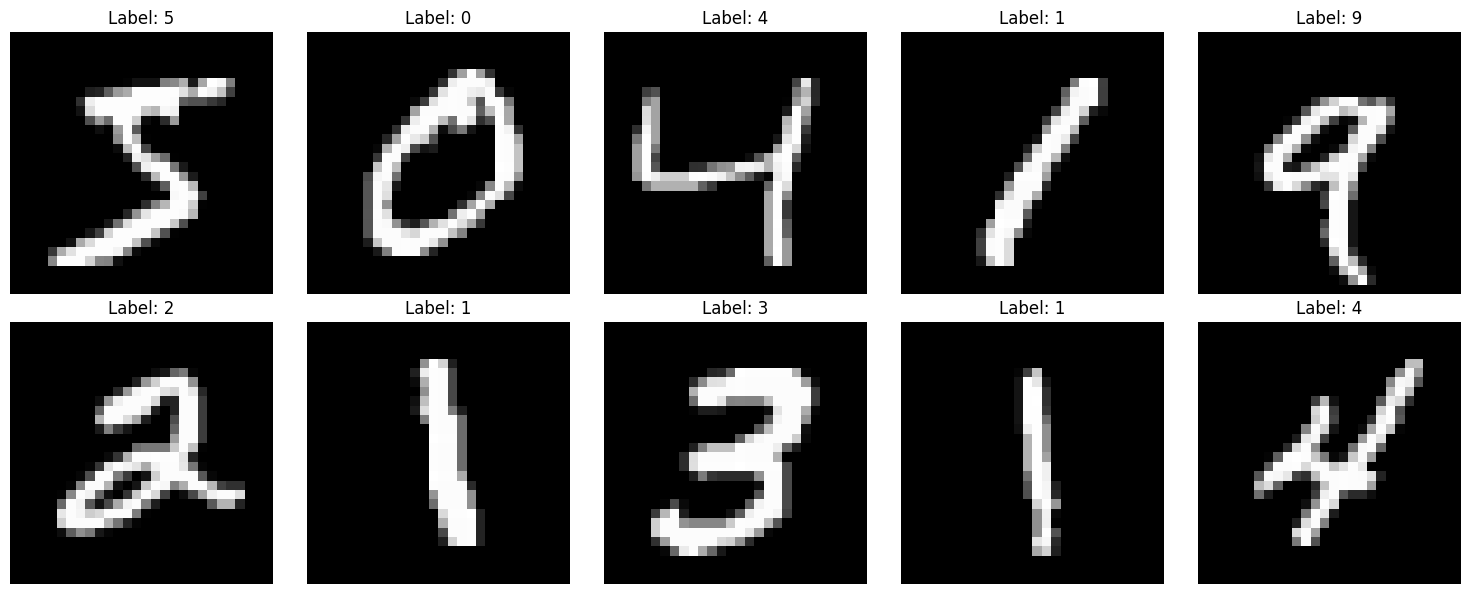

In [2]:
# Load MNIST dataset
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

train_dataset = torchvision.datasets.MNIST(
    root='cpsc8430/datasets/MNIST',
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.MNIST(
    root='cpsc8430/datasets/MNIST',
    train=False,
    download=True,
    transform=transform
)

print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# Visualize some training examples
plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_dataset[i][0].squeeze(), cmap='gray')
    plt.title(f'Label: {train_dataset[i][1]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

## Part 2: Implement Softmax Function

**TODO: Implement the softmax function from scratch**

The softmax function converts raw scores (logits) into probabilities:
$$\text{softmax}(x_i) = \frac{e^{x_i}}{\sum_{j=1}^{K} e^{x_j}}$$

**Important Hint for Numerical Stability**:
To avoid numerical overflow when computing exponentials, subtract the maximum value from each input before applying exp:
$$\text{softmax}(x_i) = \frac{e^{x_i - \max_j x_j}}{\sum_{j=1}^{K} e^{x_j - \max_j x_j}}$$

This ensures that the largest exponent is 0, preventing overflow while maintaining the same mathematical result.

**Requirements**:
- Handle numerical stability (subtract max value before exp)
- Return probabilities that sum to 1
- Work with both 1D and 2D inputs

In [4]:
def softmax(x):
    """
    Compute softmax probabilities for input scores
    
    Args:
        x: Input scores tensor of shape (batch_size, num_classes) or (num_classes,)
    
    Returns:
        Softmax probabilities tensor of same shape
    """
    ################################################################################
    # TODO: Implement softmax function
    # Hint: Use torch.exp() and torch.sum()
    # Hint: For numerical stability, subtract the max value before computing exp
    # Hint: The equation is: softmax(x_i) = exp(x_i - max_j x_j) / sum_j exp(x_j - max_j x_j)
    ################################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    max_j = torch.max(x) # Get the max_j(x_j)
    exp_x = torch.exp(torch.add(x, (-1)*max_j))
    sum_exp_x = torch.sum(exp_x)

    return torch.div(exp_x, sum_exp_x)
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ################################################################################
    #                              END OF YOUR CODE                                #
    ################################################################################


# Test your softmax implementation
test_scores = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
test_probs = softmax(test_scores)
print(f"Test scores:\n{test_scores}")
print(f"Softmax probabilities:\n{test_probs}")
print(f"Probabilities sum to 1: {torch.allclose(torch.sum(test_probs, dim=1), torch.ones(2))}")

# Test 1D input as well
test_scores_1d = torch.tensor([1.0, 2.0, 3.0])
test_probs_1d = softmax(test_scores_1d)
print(f"\n1D test scores: {test_scores_1d}")
print(f"1D softmax probabilities: {test_probs_1d}")
print(f"1D probabilities sum to 1: {torch.allclose(torch.sum(test_probs_1d), torch.tensor(1.0))}")

Test scores:
tensor([[1., 2., 3.],
        [4., 5., 6.]])
Softmax probabilities:
tensor([[0.0043, 0.0116, 0.0315],
        [0.0858, 0.2331, 0.6337]])
Probabilities sum to 1: False

1D test scores: tensor([1., 2., 3.])
1D softmax probabilities: tensor([0.0900, 0.2447, 0.6652])
1D probabilities sum to 1: True


## Part 3: Implement Linear Classifier Forward Pass

**TODO: Implement the forward pass of the linear classifier**

The forward pass computes: $f(x) = \text{softmax}(xW^T + b)$

In [13]:
def linear_classifier_forward(x, weights, bias):
    """
    Forward pass of linear classifier (returns logits, not probabilities)
    
    Args:
        x: Input features, shape (batch_size, input_features)
        weights: Weight matrix, shape (num_classes, input_features)
        bias: Bias vector, shape (num_classes,)
    
    Returns:
        Logits (raw output class scores), shape (batch_size, num_classes)
    """
    ################################################################################
    # TODO: Implement forward pass
    # Hint: Compute linear transformation: x * weights^T + bias
    # Return the logits (do NOT apply softmax here)
    ################################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return torch.add(torch.matmul(x, torch.transpose(weights, -2, 1)), bias)
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ################################################################################
    #                              END OF YOUR CODE                                #
    ################################################################################

    


# Test your forward pass implementation
batch_size = 4
input_features = 784
num_classes = 10

test_x = torch.randn(batch_size, input_features)
test_weights = torch.randn(num_classes, input_features)
test_bias = torch.randn(num_classes)

test_output = linear_classifier_forward(test_x, test_weights, test_bias)
print(f"Input shape: {test_x.shape}")
print(f"Weights shape: {test_weights.shape}")
print(f"Bias shape: {test_bias.shape}")
print(f"Output shape: {test_output.shape}")
print(f"Output probabilities sum to 1: {torch.allclose(torch.sum(test_output, dim=1), torch.ones(batch_size))}")

Input shape: torch.Size([4, 784])
Weights shape: torch.Size([10, 784])
Bias shape: torch.Size([10])
Output shape: torch.Size([4, 10])
Output probabilities sum to 1: False


## Part 4: Train Linear Classifier Using PyTorch


**TODO: Train the linear classifier using PyTorch's automatic differentiation**

Instead of implementing gradient descent manually, we'll use PyTorch's built-in optimizer and automatic differentiation. This will use the default learning rate of 0.001 and batch size of 32.

In [30]:
def train_linear_classifier(train_loader, num_epochs=10):
    """
    Train linear classifier using PyTorch's automatic differentiation
    
    Args:
        train_loader: DataLoader for training data
        num_epochs: Number of training epochs (default: 10)
    
    Returns:
        Trained weights, bias, and training history
    """
    # Initialize parameters
    input_features = 784  # 28x28 flattened
    num_classes = 10

    weights = None
    bias = None

    # Training history
    train_losses = []
    train_accuracies = []

    criterion = None
    optimizer = None
    
    
    ################################################################################
    # TODO: Initialize weights and bias, set requires_grad=True, and set up loss function and optimizer
    # Hint: 
    #   - Use torch.randn() or torch.zeros() to initialize weights and bias
    #   - Use weights.requires_grad_(True) and bias.requires_grad_(True)
    #   - Use nn.CrossEntropyLoss() and torch.optim.SGD() with lr=0.001
    ################################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    weights = torch.rand(num_classes, input_features).requires_grad_(True)
    bias = torch.rand(num_classes).requires_grad_(True)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD([weights, bias], lr=0.001, momentum=.9)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ################################################################################
    #                              END OF YOUR CODE                                #
    ################################################################################
    

    print(f"Starting training with {num_epochs} epochs, lr=0.001, batch_size=32")
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (data, targets) in enumerate(train_loader):
            # Flatten input data
            data = data.view(-1, input_features)
            
            ################################################################################
            # TODO: Forward pass, compute loss, and perform backward pass and optimization
            # Hint: 
            #   - Use your linear_classifier_forward function for the forward pass
            #   - CrossEntropyLoss expects logits, not probabilities (compute logits before softmax)
            #   - optimizer.zero_grad(), loss.backward(), optimizer.step()
            ################################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            predictions = linear_classifier_forward(data, weights, bias)
            loss = criterion(predictions, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            ################################################################################
            #                              END OF YOUR CODE                                #
            ################################################################################
            
            # Compute accuracy
            _, predicted = torch.max(predictions, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            epoch_loss += loss.item()
            
            if batch_idx % 100 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}, Loss: {loss.item():.4f}")
        
        # Compute epoch statistics
        avg_loss = epoch_loss / len(train_loader)
        accuracy = 100 * correct / total
        
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    
    return weights, bias, train_losses, train_accuracies

# Create data loader with default batch size of 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# Test training function
print("Testing training function...")
weights, bias, losses, accuracies = train_linear_classifier(train_loader)

Testing training function...
Starting training with 10 epochs, lr=0.001, batch_size=32
Epoch 1/10, Batch 0, Loss: 12.4415
Epoch 1/10, Batch 100, Loss: 3.2843
Epoch 1/10, Batch 200, Loss: 0.9501
Epoch 1/10, Batch 300, Loss: 3.1565
Epoch 1/10, Batch 400, Loss: 1.7861
Epoch 1/10, Batch 500, Loss: 0.9610
Epoch 1/10, Batch 600, Loss: 0.4730
Epoch 1/10, Batch 700, Loss: 0.4359
Epoch 1/10, Batch 800, Loss: 0.5850
Epoch 1/10, Batch 900, Loss: 1.3495
Epoch 1/10, Batch 1000, Loss: 0.3172
Epoch 1/10, Batch 1100, Loss: 1.8061
Epoch 1/10, Batch 1200, Loss: 0.9012
Epoch 1/10, Batch 1300, Loss: 1.0479
Epoch 1/10, Batch 1400, Loss: 0.8743
Epoch 1/10, Batch 1500, Loss: 0.9093
Epoch 1/10, Batch 1600, Loss: 0.6413
Epoch 1/10, Batch 1700, Loss: 0.3850
Epoch 1/10, Batch 1800, Loss: 1.0981
Epoch 1/10 - Loss: 1.4792, Accuracy: 74.69%
Epoch 2/10, Batch 0, Loss: 0.8854
Epoch 2/10, Batch 100, Loss: 0.6879
Epoch 2/10, Batch 200, Loss: 0.2145
Epoch 2/10, Batch 300, Loss: 0.6000
Epoch 2/10, Batch 400, Loss: 0.5532

## Part 5: Visualize Training Progress

Plot the training curves to see how the model learns.

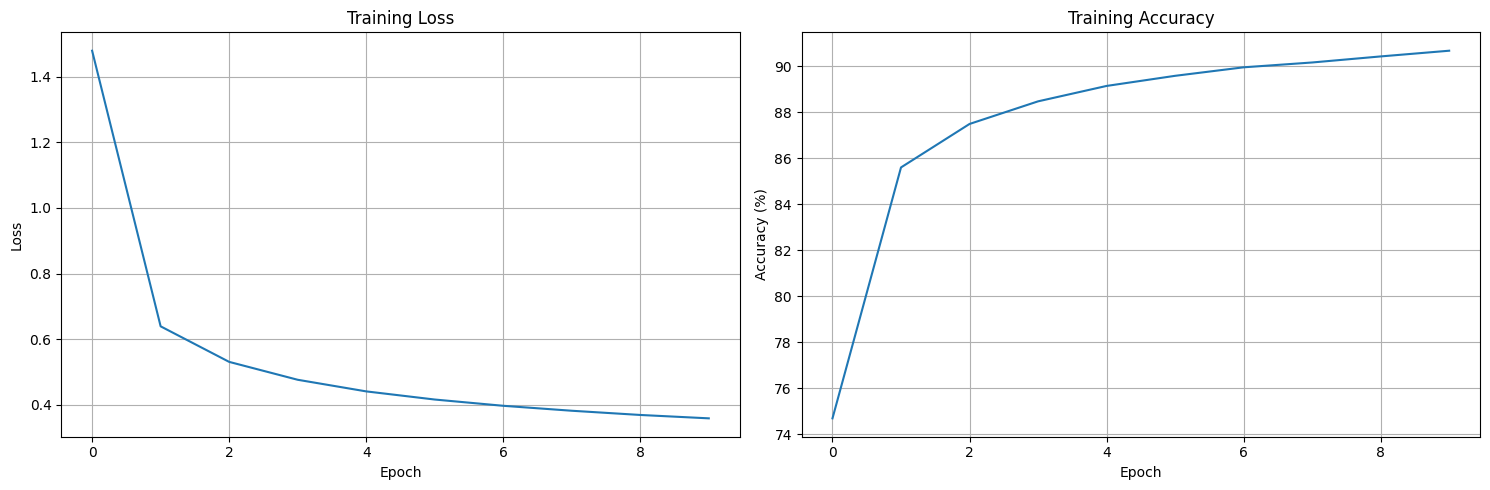

Final training accuracy: 90.68%


In [31]:
# Plot training curves
plt.figure(figsize=(15, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracies)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Final training accuracy: {accuracies[-1]:.2f}%")

## Part 6: Visualize Learned Templates

**NEW SECTION: Visualize the learned weight templates for each digit class**

The weights of a linear classifier can be interpreted as learned templates for each class. Let's visualize what the model has learned.

Visualizing learned templates...


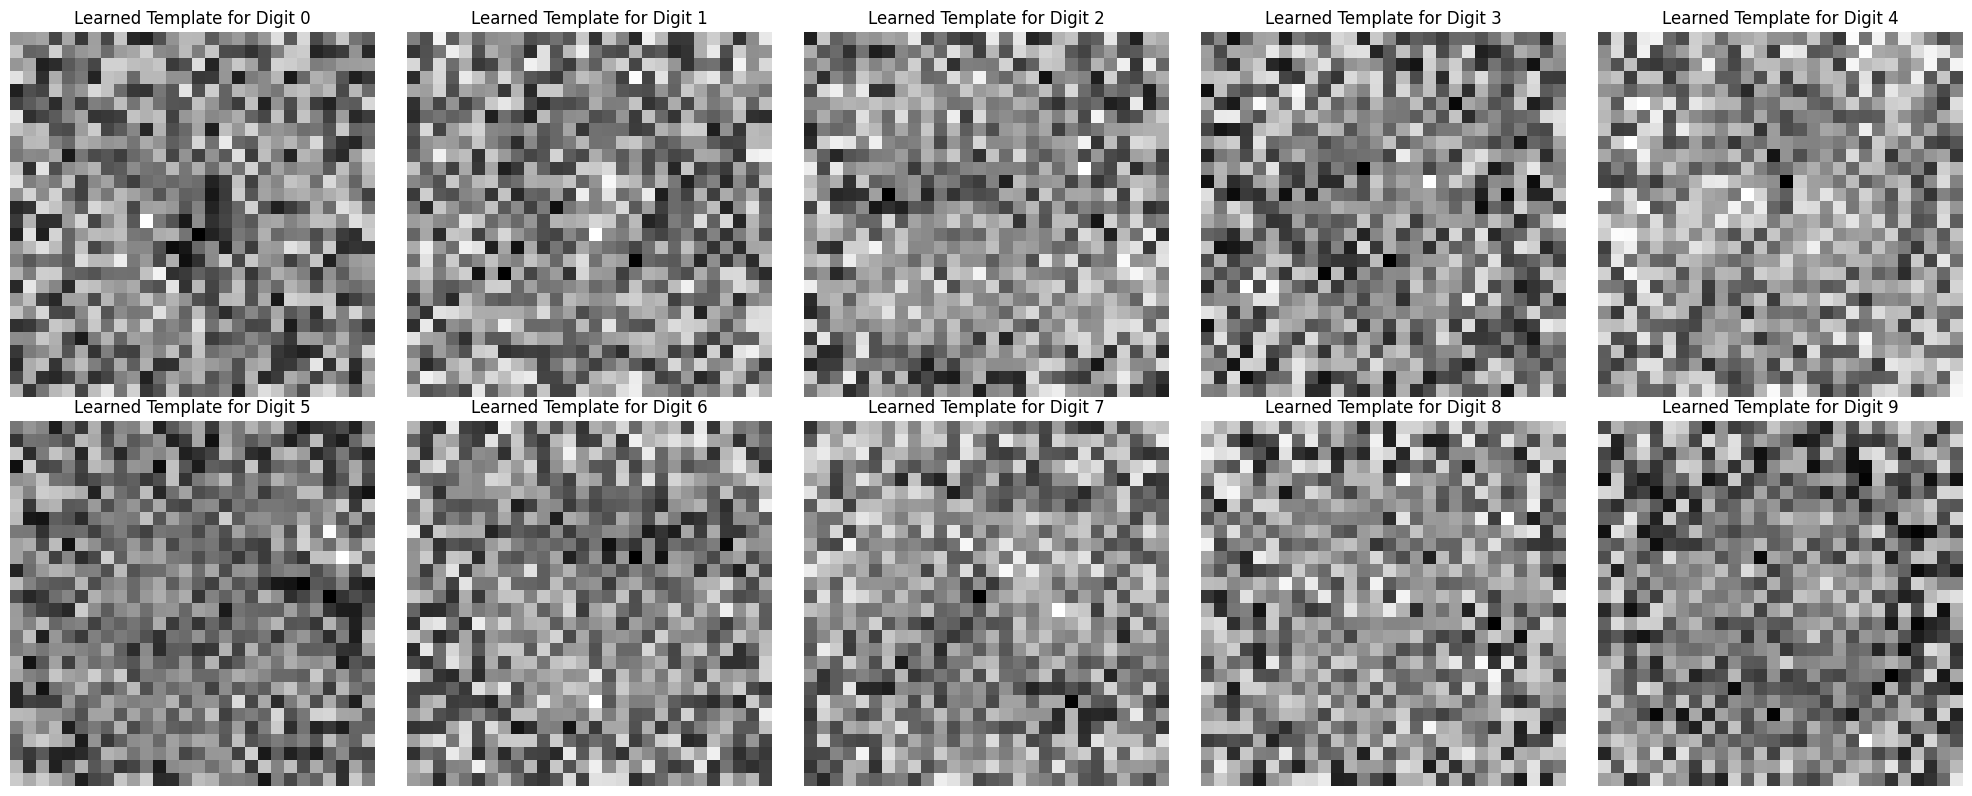

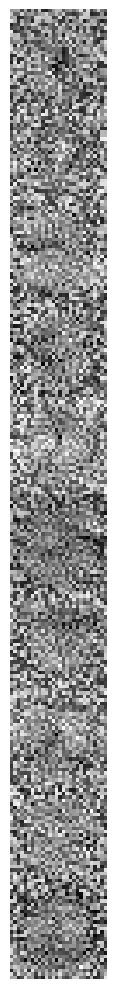

✅ Learned templates visualization saved to: all_weights_combined_learned.png


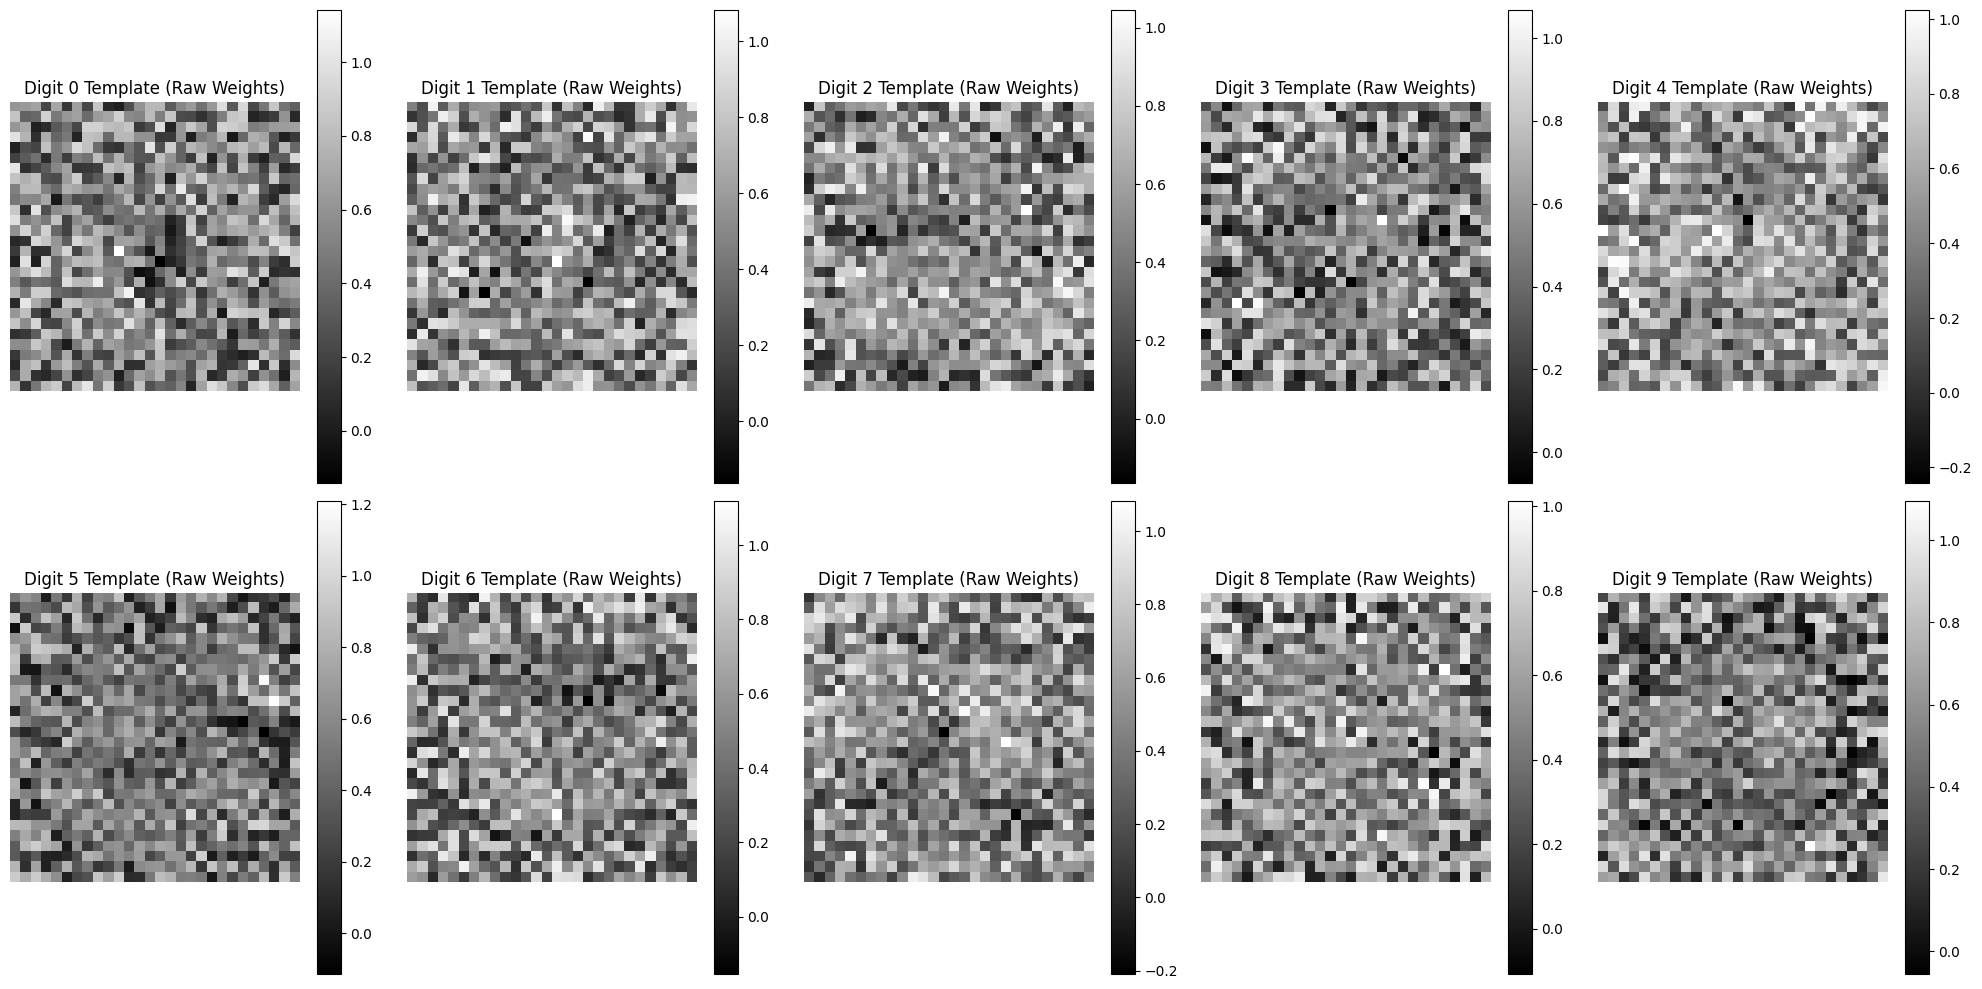

In [32]:
# Visualize learned templates
from PIL import Image

def visualize_learned_templates(weights, save_path='all_weights_combined_learned.png'):
    """
    Visualize the learned weight templates for each digit class
    
    Args:
        weights: Trained weight matrix, shape (num_classes, input_features)
        save_path: Path to save the combined visualization
    """
    # Reshape weights to 28x28 images
    num_classes, input_features = weights.shape
    assert input_features == 784, f"Expected 784 features, got {input_features}"
    
    # Create a figure with 2x5 subplots for the 10 digits
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.ravel()
    
    # Normalize weights for better visualization
    weights_normalized = weights.clone()
    for i in range(num_classes):
        # Normalize each class template to [0, 1] range
        w_min = weights[i].min()
        w_max = weights[i].max()
        if w_max > w_min:
            weights_normalized[i] = (weights[i] - w_min) / (w_max - w_min)
    
    # Plot each digit template
    for i in range(num_classes):
        # Reshape to 28x28
        template = weights_normalized[i].detach().view(28, 28).numpy()
        
        # Plot template
        axes[i].imshow(template, cmap='gray')
        axes[i].set_title(f'Learned Template for Digit {i}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Create combined visualization (similar to 01_linear_feature.ipynb)
    # Create a 10x1 grid layout (single column)
    combined_img = np.zeros((28 * 10, 28))
    
    for i in range(num_classes):
        row = i  # Each digit gets its own row

        template = weights_normalized[i].detach().view(28, 28).numpy()
        combined_img[row*28:(row+1)*28, :] = template
    
    # Display combined image
    plt.figure(figsize=(12, 10))
    plt.imshow(combined_img, cmap='gray')
    plt.axis('off')
    plt.tight_layout()
    plt.show()   
    
    # Save combined image directly as raw array
    combined_img_normalized = ((combined_img - combined_img.min()) / (combined_img.max() - combined_img.min()) * 255).astype(np.uint8)
    img = Image.fromarray(combined_img_normalized, mode='L')
    img.save(save_path)
    
    print(f"✅ Learned templates visualization saved to: {save_path}")
    return combined_img

# Visualize the learned templates
print("Visualizing learned templates...")
learned_templates = visualize_learned_templates(weights)

# Also show individual templates with more detail
plt.figure(figsize=(20, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    template = weights[i].detach().view(28, 28).numpy()
    plt.imshow(template, cmap='gray')
    plt.title(f'Digit {i} Template (Raw Weights)')
    plt.colorbar()
    plt.axis('off')
plt.tight_layout()
plt.show()

## Part 7: Test on MNIST Test Set

Evaluate the trained model on the test set to get the final accuracy.

In [33]:
def evaluate_model(test_loader, weights, bias):
    """
    Evaluate the trained model on test set
    """
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, targets in test_loader:
            # Flatten input data
            data = data.view(-1, 784)
            
            # Forward pass
            predictions = linear_classifier_forward(data, weights, bias)
            
            # Get predictions
            _, predicted = torch.max(predictions, 1)
            
            # Update statistics
            
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    return 100 * correct / total

# Evaluate model
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)
test_accuracy = evaluate_model(test_loader, weights, bias)

print(f"Test Accuracy: {test_accuracy:.2f}%")

# IMPORTANT: This accuracy should be greater than 90% for full credit
# assert test_accuracy > 90.0, f"Test accuracy {test_accuracy:.2f}% is below the required threshold of 90%"
# print(f"✅ Test accuracy {test_accuracy:.2f}% meets the requirement of >90%!")

# Store the result for grading
test_accuracy_result = test_accuracy

# Test metadata for Gradescope auto-grading
# This cell will be automatically executed and evaluated
print(f"\n🎯 Final Test Result: {test_accuracy_result:.2f}%")
print(f"📊 Grading Status: {'✅ PASSED' if test_accuracy_result > 90.0 else '❌ FAILED'}")
print(f"🎓 Points Earned: {60 if test_accuracy_result > 90.0 else 0}/60 for accuracy")

Test Accuracy: 90.81%

🎯 Final Test Result: 90.81%
📊 Grading Status: ✅ PASSED
🎓 Points Earned: 60/60 for accuracy


## Part 8: Load Pre-saved Weights and Compare

**NEW SECTION: Load pre-saved weight images and apply them to the linear classifier**

In this section, we'll load the pre-saved weight images (like `all_digits_combined_learned.png`) and use them as weights for the linear classifier. We'll then compare the accuracy with the original implementation from 01_linear_feature.ipynb.

**Key Features:**
1. **Load images** using the same approach as 01_linear_feature.ipynb
2. **Apply eta adjustment** to modify the loaded images
3. **Create weight matrix** [10, 784] from normalized images
4. **Test accuracy** using the linear classifier evaluation function
5. **Compare results** across different eta values

Loading weights from saved image...

Testing with eta = 1
Test Accuracy: 0.11%
Visualizing weights with eta=1...


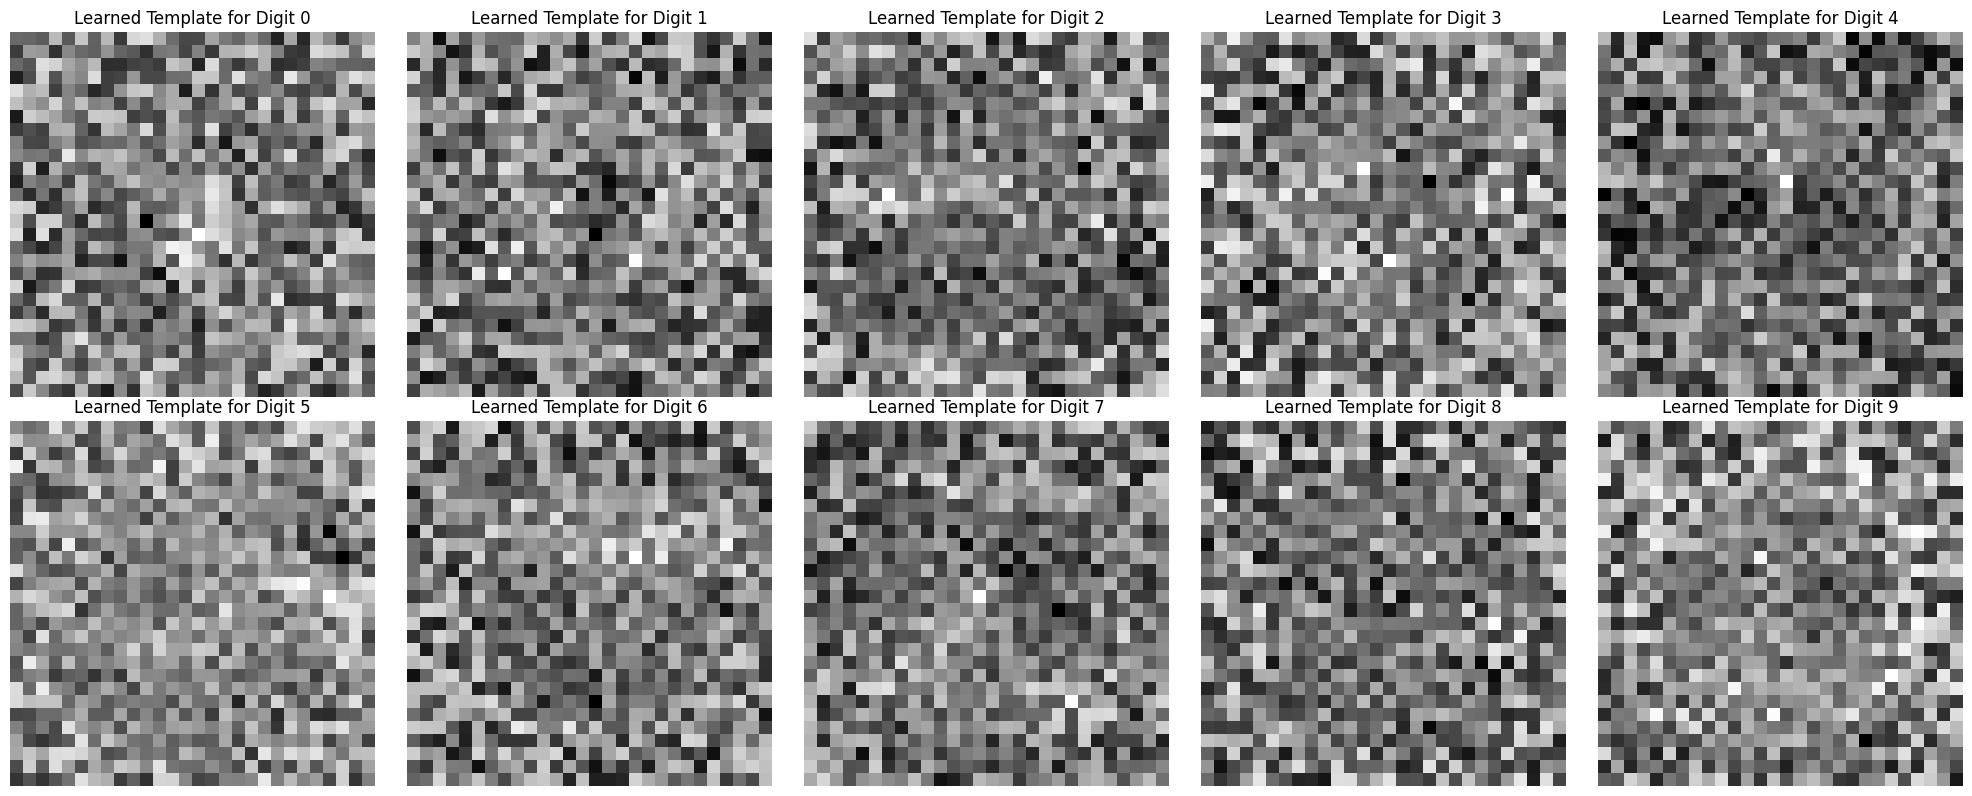

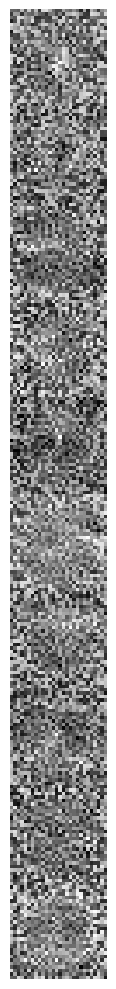

✅ Learned templates visualization saved to: loaded_weights_eta_1.00.png


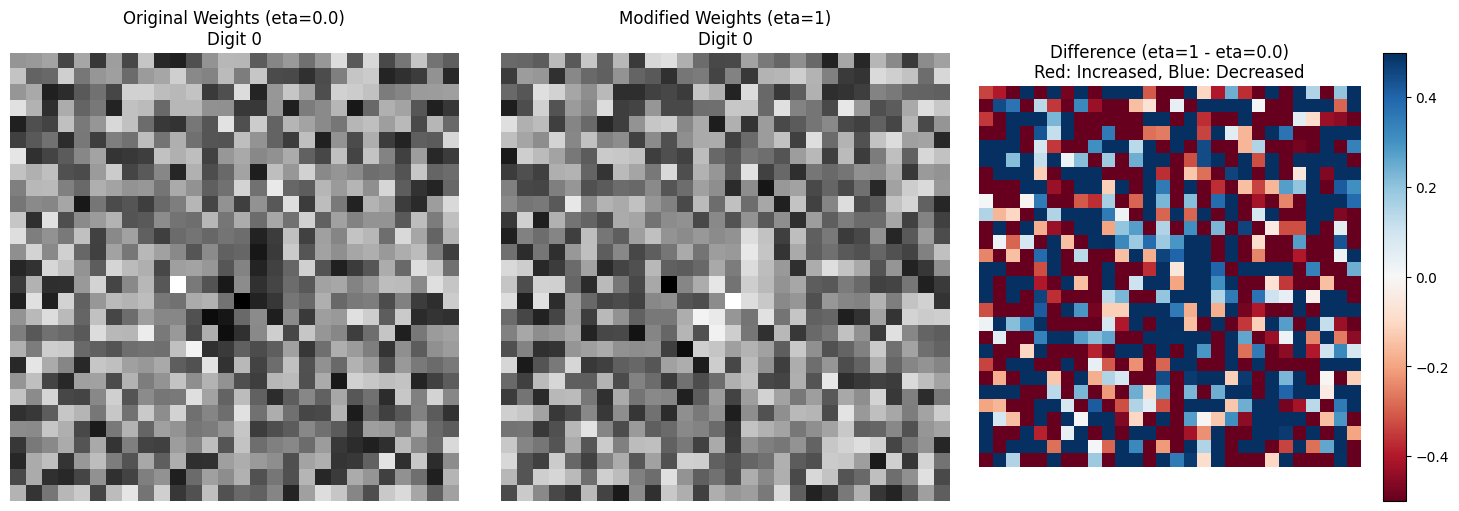

✅ Eta=1 analysis completed



In [40]:
# Import the linear classifier functions from 01_linear_feature.ipynb
from cpsc8430.classifiers import (
    load_and_preprocess_image,
    create_weight_matrix,
    create_mnist_test_loader,
    evaluate_linear_classifier,
    create_random_bias
)

# Load weights from the saved image with different eta values
print("Loading weights from saved image...")

################################################################################
# TODO: Try different values of eta (e.g., 0.0, 0.25, 0.5, 0.75, 1.0) and observe how the test accuracy changes.
#       You can loop over several eta values and report the results for each.
eta = 1
################################################################################


print(f"\n{'='*50}")
print(f"Testing with eta = {eta}")
print(f"{'='*50}")

try:
    # Load and preprocess image using eta (similar eta in 01_linear_feature.ipynb)
    img_normalized = load_and_preprocess_image('all_weights_combined_learned.png', eta)
    
    # Create weight matrix [10, 784] from the normalized image
    weight_matrix = create_weight_matrix(img_normalized)
    
    # Create random bias
    bias = torch.randn(10)
    
    # Create test loader
    test_loader = create_mnist_test_loader()
    
    # Evaluation function
    def evaluate():
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                # Flatten the images
                images = images.view(-1, 784)
                
                # Forward pass: compute scores
                scores = torch.mm(images, weight_matrix.t()) + bias
                
                # Get predictions
                _, predicted = torch.max(scores, 1)
                
                # Update statistics
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        return 100 * correct / total
    
    # Test the classifier
    accuracy = evaluate()
    print(f"Test Accuracy: {accuracy:.2f}%")
    
    # Visualize the loaded weights with current eta
    print(f"Visualizing weights with eta={eta}...")
    visualize_learned_templates(weight_matrix, f'loaded_weights_eta_{eta:.2f}.png')
    
    # Show the effect of eta on a sample digit template
    plt.figure(figsize=(15, 5))
    
    # For comparison, also load the original weights (eta=0.0)
    img_normalized_orig = load_and_preprocess_image('all_weights_combined_learned.png', eta=0.0)
    original_weights = create_weight_matrix(img_normalized_orig)
    current_weights = weight_matrix
    
    # Show comparison for digit 0
    plt.subplot(1, 3, 1)
    template_orig = original_weights[0].detach().view(28, 28).numpy()
    plt.imshow(template_orig, cmap='gray')
    plt.title(f'Original Weights (eta=0.0)\nDigit 0')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    template_current = current_weights[0].detach().view(28, 28).numpy()
    plt.imshow(template_current, cmap='gray')
    plt.title(f'Modified Weights (eta={eta})\nDigit 0')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    difference = template_current - template_orig
    plt.imshow(difference, cmap='RdBu', vmin=-0.5, vmax=0.5)
    plt.title(f'Difference (eta={eta} - eta=0.0)\nRed: Increased, Blue: Decreased')
    plt.colorbar()
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Eta={eta} analysis completed")
    
except Exception as e:
    print(f"❌ Error with eta={eta}: {e}")

print(f"\n{'='*60}")


## Inline Questions

### Question 1
What is the purpose of the softmax function in multi-class classification? How does it help with gradient descent?

$\color{blue}{\textit{Your Answer:}}$

The softmax functions works to create a probability distribution that is differentiable. This key aspect of the softmax function is what enables GD to work in the first place.

### Question 2
What is the significance of the cross-entropy loss function in classification problems? Why is it preferred over mean squared error?

$\color{blue}{\textit{Your Answer:}}$

Cross entropy loss focuses on how much the scores diverge from the target since it relies on probablistic calculations. This results in a steeper optimization when compared to MSE (which is not divergent by nature nor reflects probability, thus regressive problems work better than classification). This means that classifications are more likely to fall into local minima and vanishing gradients if MSE is used. 



### Question 3
**Analyze the learned templates visualization**

Look at the learned weight templates for each digit class. What patterns do you observe? How do these templates relate to the actual digit shapes? Why might some templates look clearer than others? What does this tell us about how the linear classifier learns to distinguish between different digit classes?

$\color{blue}{\textit{Your Answer:}}$

You can see the general shape of the numbers. Some are more crumby than others, but all have the general curves. I think some look different than others because people write those numbers very differently. The classifier seems to learn the edges of the shapes and even highlight the differences rather than the exact shape. Structured, linear data (with linear separation) fairs better than more complex variations which we see with certain digits (like `4` and even `1`).



### Question 4
**Weight loading and comparison**

When you load the pre-saved weights, 'all_weights_combined_learned.png' , from the image file, how does the testing accuracy compare to the direct trained weights (Part 7)?  What is the major reason to cause differences in performance? 

$\color{blue}{\textit{Your Answer:}}$

The testing accuracy is not as good as the direct trained weights. At `eta = 0`, the accuracy is ~65%. While the direct trained weights gives us 90%> accuracy. The major reason I see is with the bias vector. Rather than used trained, tuned biases, a random vector of biases is created in its stead. Weights and biases go hand-in-hand during training.

### Question 5
**Effect of Different Eta Values on Testing Accuracy**

In Part 8, try different values of $\eta$ from the set $\{0, 0.25, 0.5, 0.75, 1\}$ when loading the pre-saved weights from the image file. For each $\eta$, report the testing accuracy you obtain.

$\color{blue}{\textit{Your Answer:}}$

- Testing accuracy for $\eta=0$: 65.29%
- Testing accuracy for $\eta=0.25$: 66.64%
- Testing accuracy for $\eta=0.5$: 9.8%
- Testing accuracy for $\eta=0.75$: 0.11%
- Testing accuracy for $\eta=1$: 0.11%

How does the trend of testing accuracy as $\eta$ changes compare to what you observed in 01_linear_feature.ipynb? Why do you think the trend is different in this notebook?

In the 01_linear_feature.ipynb we see the opposite trend as the grayscale changes. This is likely because the weights from the learned png are learned such that negative squares (darker) are associated with divergence and positive (lighter) with convergence. 




